In [1]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
import os, random
import time
from PIL import Image
import copy
import pandas as pd
import matplotlib.pyplot as plt
import cv2

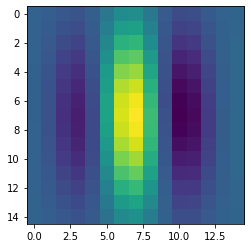

In [191]:
import cv2
ksize = 15
sigma = 3
theta = 3.14/1

lamda = 0.9
gamma = 0.7
phi = 0.3

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
plt.imshow(kernel)
fltr = torch.zeros((3,3,ksize,ksize))
for i in range(3):
    fltr[:,:]=torch.tensor(kernel)
    
def gabor(img):
    out = F.conv2d(img.unsqueeze(0), weight=fltr, bias=torch.tensor([3,1,1], dtype = torch.float), padding=2)
    return out



# Loading data

In [192]:
#Data transformations for data augmentation
jitter_param = 0.3
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-30,30), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, filt = None, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.filt = filt
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        #img = cv2.imread(self.imgs[ix])
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        
        
        #ksize = 5
        #sigma = 0.9
        #theta = 3.14/3
        #lamda = 1.5
        #gamma = 0.8
        #phi = 0

        #kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.filter2D(img, cv2.CV_32FC3, kernel)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = Image.fromarray(img.astype(np.uint8))
        if self.transform:
            img = self.transform(img)
            img=self.filt(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values



In [193]:
#Hyperparameters. train_val_split means the fraction of images intended for train (max value=1)
train_val_split = 0.85
batch_size = 6

train_dataset = Dataset(imgs[0:int(train_val_split*len(imgs))], 
                        labels[0:int(train_val_split*len(imgs))], 
                        filt = gabor,
                        transform = train_transform)
val_dataset = Dataset(imgs[int(train_val_split*len(imgs)):len(imgs)], 
                      labels[int(train_val_split*len(imgs)):len(imgs)], 
                      filt = gabor,
                      transform = val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


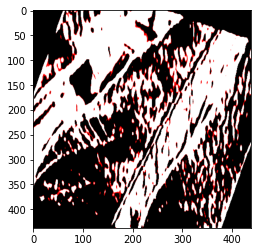

In [196]:
plt.imshow(train_dataset.__getitem__(10)[0][0].permute(1, 2, 0))

# Loading model

In [57]:
#Load trained model to re-train
model = torch.load('./ResNet50-1.h5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RuntimeError: CUDA error: out of memory

In [6]:
#Load ResNet50 new model

model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Load vgg16 new model

model = torchvision.models.vgg16(pretrained=True)
model.classifier.add_module('7', nn.ReLU())
model.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
model.classifier.add_module('9', nn.Linear(1000, 5))
model.classifier.add_module('10', nn.LogSoftmax(dim=1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train

In [7]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    losses = np.zeros((2,num_epochs))
    acertos= np.zeros((2,num_epochs))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       
        for phase in range(2):
            if phase == 0:
                model.train()  # Pon a rede en training mode
            else:
                model.eval()   # Pon a rede en evaluate mode

            running_loss = 0.0
            running_corrects = 0
            itera = 0
          
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                itera += 1
                if itera%1000 == 0:
                    print('images:', itera)
                    
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 0:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 0:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 0:
              losses[0, epoch]= epoch_loss
              acertos[0, epoch]= epoch_acc
            else:
              losses[1, epoch]= epoch_loss
              acertos[1, epoch]= epoch_acc

            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('train loss:', list(losses[0]))
    print()
    print('val loss:', list(losses[1]))
    print()
    print('train acc:', list(acertos[0]))
    print()
    print('val acc:', list(acertos[1]))
    # Cargamos os mellores pesos obtidos ao longo das iteracións
    model.load_state_dict(best_model_wts)
    return model, losses, acertos

In [8]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
images: 1000
images: 2000
images: 3000
0 Loss: 1.1380 Acc: 0.6131
1 Loss: 1.0457 Acc: 0.6271

Epoch 1/4
----------
images: 1000
images: 2000
images: 3000
0 Loss: 1.0639 Acc: 0.6266
1 Loss: 1.0055 Acc: 0.6408

Epoch 2/4
----------
images: 1000
images: 2000
images: 3000
0 Loss: 1.0258 Acc: 0.6383
1 Loss: 1.0230 Acc: 0.6545

Epoch 3/4
----------
images: 1000
images: 2000
images: 3000
0 Loss: 1.0098 Acc: 0.6446
1 Loss: 1.1120 Acc: 0.6502

Epoch 4/4
----------
images: 1000
images: 2000
images: 3000
0 Loss: 0.9931 Acc: 0.6456
1 Loss: 0.9193 Acc: 0.6766

Training complete in 70m 11s
Best val Acc: 0.676636
train loss: [1.1379689356561948, 1.0638515140570206, 1.0258199629457472, 1.0097734325390726, 0.9930504324519825]

val loss: [1.0456950913522844, 1.0054995498924613, 1.0229546712380704, 1.1120073838768718, 0.9192648062221358]

train acc: [0.6130752735470391, 0.6266014185957002, 0.63831308077198, 0.6445812943311157, 0.6456259965909715]

val acc: [0.6271028037383178, 0.6408

# Results

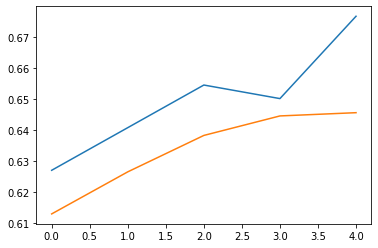

In [10]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

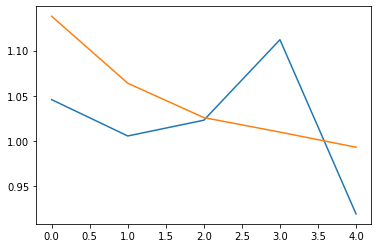

In [11]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [ ]:
PATH='./ResNet50-gabbor.h5'
torch.save(model, PATH)

In [ ]:
last acc: [0.87507] resnet